## Outline
- num of features: 1200
- using cv for logistic regression and ridge regression
- since ridge perform better -> so output ridge regression

In [25]:
# import package
import numpy as np 
import pandas as pd 
import gc
import datetime
import warnings
import seaborn as sns
import math

from sklearn.preprocessing import OneHotEncoder
from scipy.stats import norm, rankdata

# scaling
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# Dimension Reduction
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.cluster import KMeans

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluation
from tqdm import tqdm_notebook
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Model
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, ExtraTreesRegressor                   
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import ComplementNB
from xgboost import XGBClassifier
#import xgboost as xgb
from catboost import CatBoostRegressor, CatBoostClassifier
from vecstack import stacking


warnings.filterwarnings('ignore')

In [26]:
# read data
data_train = pd.read_csv("../input/train.csv", encoding = 'utf-8-sig')
data_test = pd.read_csv("../input/test.csv", encoding = 'utf-8-sig')
data_sample = pd.read_csv("../input/sample_submission.csv", encoding = 'utf-8-sig')

In [27]:
# test set contains all columns in the data_train except target
data_train.columns[~data_train.columns.isin(data_test.columns)]

Index(['target'], dtype='object')

In [28]:
# get missing value variable name
a = pd.DataFrame(data_train.isnull().any()).reset_index().rename(columns={"index":"name",0:"have_na"})
print("features that have na:", a[a["have_na"]==True].name)

features that have na: Series([], Name: name, dtype: object)


check imbalance: target
0    179902
1     20098
dtype: int64


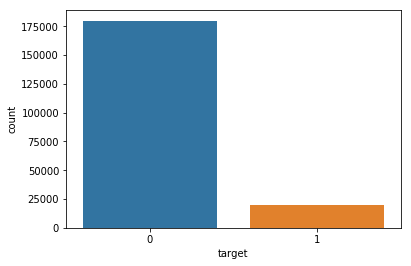

In [29]:
# imbalance data
print("check imbalance:", data_train.groupby(by="target").size())
sns.countplot(x="target", data=data_train)

In [30]:
# check data type before scaling (since string cannot scale)
[col for col in data_train.columns if data_train[col].dtype!=float]

['ID_code', 'target']

In [31]:
# [v5] add more features
col = [col for col in data_train.columns if col not in ("ID_code", "target")]
train_target = data_train["target"]
data_train = data_train[col]
ID = data_test["ID_code"]
data_test = data_test[col]
print("# of columns originally:", data_train.shape[1])

# of columns originally: 200


In [32]:
# top10 variables highly correlated with target
data_train.apply(lambda x: abs(x.corr(train_target))).sort_values(ascending = False)[:10]

var_81     0.080917
var_139    0.074080
var_12     0.069489
var_6      0.066731
var_110    0.064275
var_146    0.063644
var_53     0.063399
var_26     0.062422
var_76     0.061917
var_174    0.061669
dtype: float64

Text(0.5,1,'Distribution of stds of all columns (before scaling)')

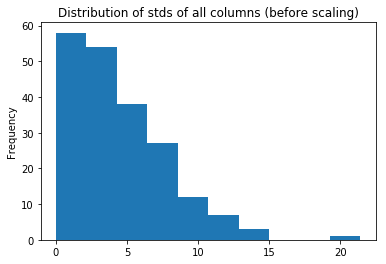

In [33]:
data_train.std().plot('hist')
plt.title('Distribution of stds of all columns (before scaling)')

Text(0.5,1,'Distribution of means of all columns')

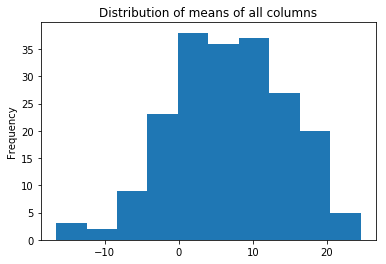

In [34]:
data_train.mean().plot('hist')
plt.title('Distribution of means of all columns')

In [35]:
# [feature added] new added features
for df in [data_train, data_test]:   
    df["mean"] = df.mean(axis=1)
    df["skew"] = df.skew(axis=1)
    df["std"] = df.std(axis=1)
    df["kurt"] = df.kurt(axis=1)
    df["max"] = df.max(axis=1)
    df["min"] = df.min(axis=1)
    df["max_min"] = df["max"] - df["min"]
    df["mean_std"] = df["mean"] - df["std"]


In [36]:
merged_df = pd.concat([data_train, data_test])

In [37]:
for col in merged_df:
    # Normalize the data, so that it can be used in norm.cdf(), as though it is a standard normal variable
    merged_df[col] = ((merged_df[col] - merged_df[col].mean()) / merged_df[col].std()).astype('float32')

    # Square
    merged_df[col+'_s'] = merged_df[col] * merged_df[col]

    # Cube
    merged_df[col+'_c'] = merged_df[col] * merged_df[col] * merged_df[col]

    # 4th power
    merged_df[col+'_q'] = merged_df[col] * merged_df[col] * merged_df[col] * merged_df[col]

    # Cumulative percentile (not normalized)
    merged_df[col+'_r'] = rankdata(merged_df[col]).astype('float32')

    # Cumulative normal percentile
    merged_df[col+'_n'] = norm.cdf(merged_df[col]).astype('float32')

In [38]:
print("# of features to train the model:", merged_df.shape[1])

# of features to train the model: 1248


In [39]:
data_train = merged_df[:len(data_train)]
data_test = merged_df[len(data_train):]

In [40]:
scaler = MinMaxScaler(feature_range=[0, 1])
train_scaled = scaler.fit_transform(data_train)
test_scaled = scaler.transform(data_test)

train_scaled = pd.DataFrame(train_scaled)
test_scaled = pd.DataFrame(test_scaled)

In [ ]:
%%time
from sklearn.pipeline import Pipeline
print("---> Logistic Regression (code seems wrong) <---")

kf = StratifiedKFold(n_splits=10,shuffle=False,random_state=0)
roc_cv =[]
np.zeros(len(test_scaled))
oof_preds = np.zeros(len(train_scaled))
predictions = np.zeros(len(test_scaled))


i=1
for train_index,test_index in kf.split(train_scaled,train_target):
    print('{} of KFold {}'.format(i,kf.n_splits))
    
    xtr,xvl = train_scaled.loc[train_index], train_scaled.loc[test_index]
    ytr,yvl = train_target.loc[train_index], train_target.loc[test_index]
    
    #model
    
    lr = Pipeline([
        ('scaler', StandardScaler()),
        #('qt', QuantileTransformer(output_distribution='normal')),
        ('lr_clf', LogisticRegression(class_weight = 'balanced', C = 1, solver = 'lbfgs', random_state = 0, max_iter=1500))
        ])
    #lr = LogisticRegression(class_weight = 'balanced', C = 1, solver = 'lbfgs', random_state = 0)
    
    lr.fit(xtr,ytr)
    val_pred = lr.predict_proba(xvl)[:,1]
    print("AUC = {}".format(roc_auc_score(yvl, val_pred)))
    roc_cv.append(roc_auc_score(yvl, val_pred))    

    test_fold_pred = lr.predict_proba(test_scaled)[:,1]
    predictions += test_fold_pred
        
    oof_preds[test_index] = val_pred

    i+=1
    
#print("CV score: {:<8.5f}".format(roc_auc_score(train_target, oof)))

In [ ]:
pd.DataFrame(pd.Series(predictions, index=ID, name = "target")).to_csv("sub_logistic_cv.csv")

In [ ]:
# %%time
# # alpha 0.0001
# ridge = Ridge(alpha = 0.0005, normalize = True, random_state = 0)
# ridge_score = cross_val_score(ridge, train_scaled, train_target, cv=10, scoring='roc_auc')
# print("average cv score of ridge regression model:", np.mean(ridge_score))

In [ ]:
# %%time
# print("logistic regression cv score: 0.8928")
# logistic = LogisticRegression(class_weight = 'balanced', C = 1, solver = 'lbfgs', random_state = 0)
# logistic_score = cross_val_score(logistic, train_scaled, train_target, cv=10, scoring='roc_auc')
# print("average cv score of logistic regression model:", np.mean(logistic_score))

In [ ]:
# ridge.fit(train_scaled, train_target)
# predictions = ridge.predict(test_scaled)

In [ ]:
# pd.DataFrame(pd.Series(predictions, index=ID, name = "target")).to_csv("sub_ridge_cv.csv")

In [ ]:
# %%time
# print("---> Ridge Regression CV output (code seems wrong, the output only 0.49 accuracy) <---")


# kf = StratifiedKFold(n_splits=10,shuffle=False,random_state=0)
# oof = np.zeros(len(train_scaled))
# predictions = np.zeros(len(test_scaled))



# i=1
# for train_index,test_index in kf.split(train_scaled,train_target):
#     print('{} of KFold {}'.format(i,kf.n_splits))
    
#     xtr,xvl = train_scaled.loc[train_index], train_scaled.loc[test_index]
#     ytr,yvl = train_target.loc[train_index], train_target.loc[test_index]
    
#     #model
#     ridge = Ridge(alpha = 0.0001, normalize = True,random_state = 0)
                  
#     ridge.fit(xtr,ytr)
#     oof[test_index] = ridge.predict(xvl)
    
#     predictions += ridge.predict(test_scaled) / kf.n_splits

#     i+=1
    
# print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))

In [ ]:
# print("---> Logistic Regression (code seems wrong) <---")
# %%time
# kf = StratifiedKFold(n_splits=10,shuffle=False,random_state=0)
# oof = np.zeros(len(train_scaled))
# predictions = np.zeros(len(data_test))
# pred_test_full = 0
# cv_score =[]


# i=1
# for train_index,test_index in kf.split(train_scaled,train_target):
#     print('{} of KFold {}'.format(i,kf.n_splits))
    
#     xtr,xvl = train_scaled.loc[train_index], train_scaled.loc[test_index]
#     ytr,yvl = train_target.loc[train_index], train_target.loc[test_index]
    
#     #model
#     lr = LogisticRegression(class_weight = 'balanced', C = 1, solver = 'lbfgs', random_state = 0)
#     lr.fit(xtr,ytr)
#     oof[test_index] = lr.predict_proba(xvl)[:,1]
    
#     #score = roc_auc_score(yvl,lr.predict(xvl))
#     #print('ROC AUC score:',score)
#     #cv_score.append(score)    

#     #pred_test = lr.predict_proba(x_test)[:,1]
#     #pred_test_full +=pred_test
#     predictions += lr.predict_proba(test_scaled)[:,1] / kf.n_splits

#     i+=1
    
# print("CV score: {:<8.5f}".format(roc_auc_score(train_target, oof)))

In [ ]:
# get output
#pd.DataFrame(pd.Series(oof, index=ID, name = "target")).to_csv("subm_ridge_cv.csv")